In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path

#IMAGE_PATH = "data/az104m5yyrrjdcq8rfqk.jpg"
#INPUT_POINT = (321, 230)
IMAGE_PATH = "data/apple_5x4.jpg"
INPUT_POINT = (960, 810)

ENC_MODEL_PATH = "models/image_encoder_vit_b.onnx"
SAM_MODEL_PATH = "models/sam_vit_b_01ec64.onnx"

# Load the image

(1620, 1920, 3)


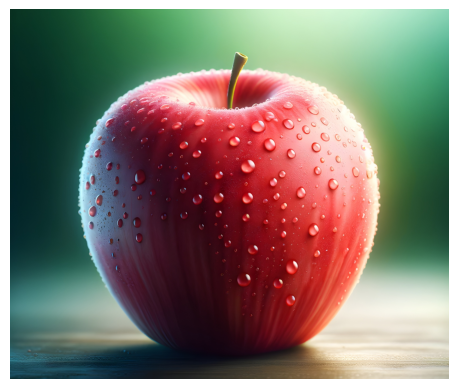

In [3]:
import cv2
from scripts.image import show_image_from_ndarray

image = cv2.imread(IMAGE_PATH)
orig_image_width, orig_image_height = image.shape[1], image.shape[0]
print(image.shape)
show_image_from_ndarray(image)

# Load SAM module

In [4]:
from scripts.sam import SegmentationAnythingModule

sam_module = SegmentationAnythingModule(ENC_MODEL_PATH, SAM_MODEL_PATH)

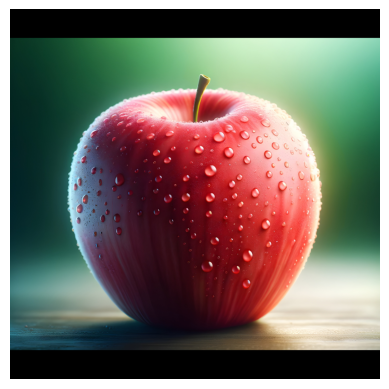

In [5]:
(
    image_processed,
    pad_h,
    pad_w,
    resize_rate,
    orig_image_height,
    orig_image_width,
) = sam_module.generate_padded_image(image)

show_image_from_ndarray(image_processed)

# Encoder

In [6]:
import time

start = time.time()
embeddings = sam_module.generate_image_embedding(image_processed, pad_h, pad_w)
end = time.time()
print(f"Time elapsed: {end - start} seconds")
embeddings.shape

Time elapsed: 0.9344873428344727 seconds


(1, 256, 64, 64)

# Decoder

In [17]:
longer_side_size_resized_image = max(
    int(orig_image_width * resize_rate), int(orig_image_height * resize_rate)
)

masks = sam_module.decode_by_point(
    embeddings,
    INPUT_POINT,
    resize_rate,
    longer_side_size_resized_image,
)


(1620, 1920)


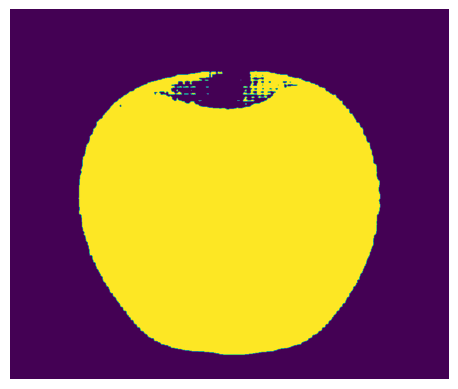

In [9]:
mask = sam_module.mask_post_process(
    masks[0][0], pad_h, pad_w, orig_image_height, orig_image_width
)
print(mask.shape)
show_image_from_ndarray(mask)

# Map

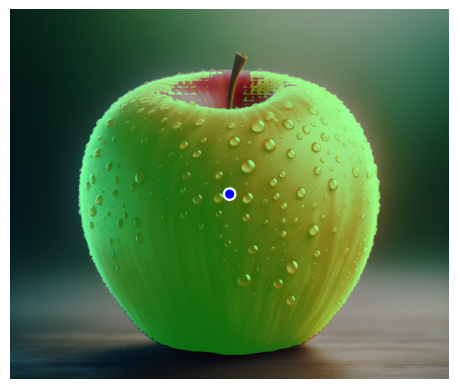

In [10]:
import numpy as np

mask_rgb = np.ones((image.shape[0], image.shape[1], 3), dtype=np.uint8) * 1
where_nonzero = np.where(mask > 0)
mask_rgb[where_nonzero[0], where_nonzero[1], :] = np.array([0, 255, 0])

result = cv2.addWeighted(image, 0.6, mask_rgb, 0.4, 2.2)
result = cv2.circle(result, INPUT_POINT, 30, (255, 255, 255), -1)
result = cv2.circle(result, INPUT_POINT, 20, (255, 0, 0), -1)

show_image_from_ndarray(result)

# BBOX input

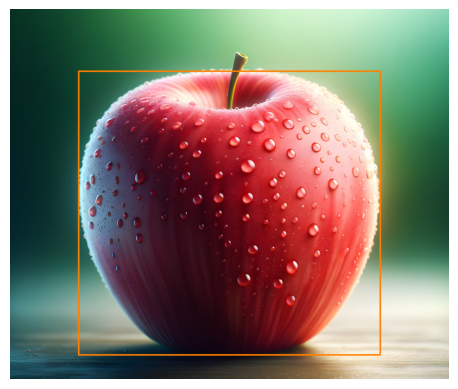

In [15]:
# Get largest contour
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Get bounding box
bbox_x, bbox_y, bbox_w, bbox_h = cv2.boundingRect(largest_contour)
bbox_x1, bbox_y1, bbox_x2, bbox_y2 = bbox_x, bbox_y, bbox_x + bbox_w, bbox_y + bbox_h

# Draw bounding box rectangle with image
image_wi_bbox = cv2.rectangle(
    image, (bbox_x1, bbox_y1), (bbox_x2, bbox_y2), (0, 128, 255), 5
)

show_image_from_ndarray(image_wi_bbox)

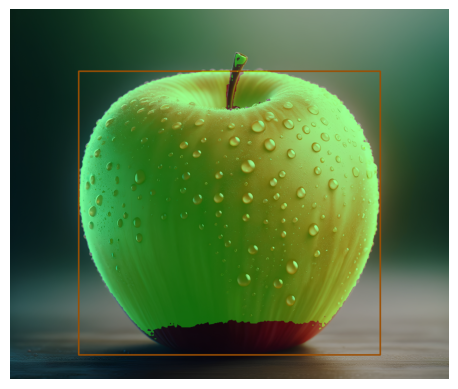

In [20]:
masks_wi_bbox = sam_module.decode_by_bbox_xyxy(
    embeddings,
    [bbox_x1, bbox_y1, bbox_x2, bbox_y2],
    resize_rate,
    longer_side_size_resized_image,
)

mask = sam_module.mask_post_process(
    masks_wi_bbox[0][0], pad_h, pad_w, orig_image_height, orig_image_width
)

mask_rgb = np.ones((image.shape[0], image.shape[1], 3), dtype=np.uint8) * 1
where_nonzero = np.where(mask > 0)
mask_rgb[where_nonzero[0], where_nonzero[1], :] = np.array([0, 255, 0])

show_image_from_ndarray(cv2.addWeighted(image_wi_bbox, 0.6, mask_rgb, 0.4, 2.2))